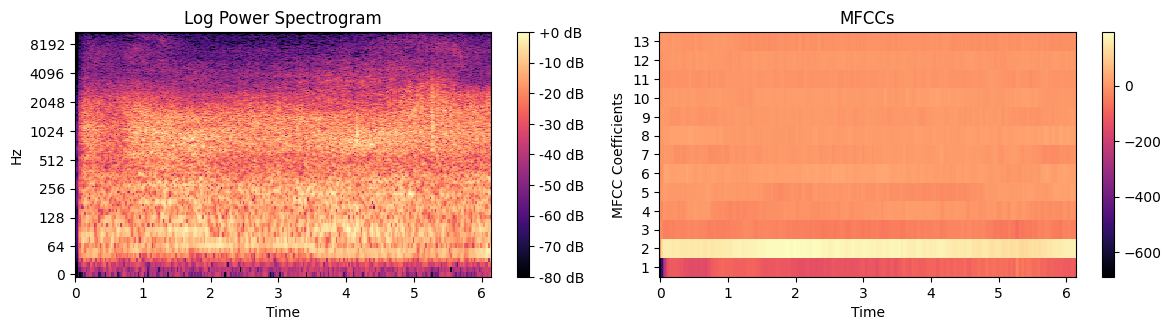

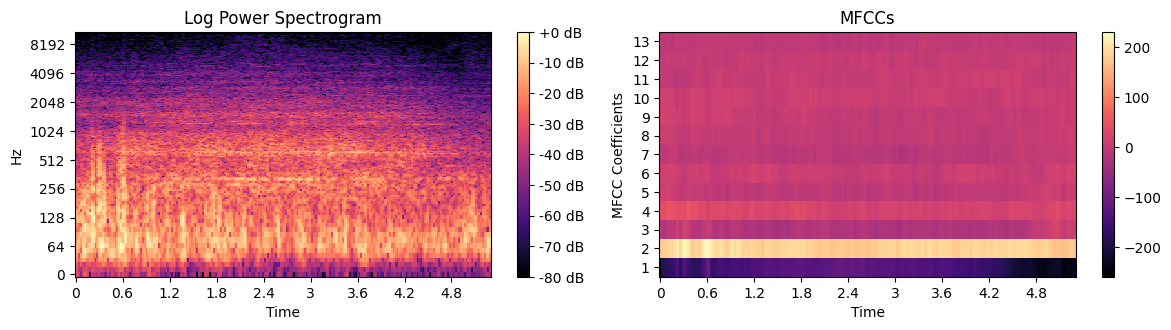

Validation accuracy: 0.9841269841269841
              precision    recall  f1-score   support

         Car       0.97      1.00      0.98        32
        Tram       1.00      0.97      0.98        31

    accuracy                           0.98        63
   macro avg       0.98      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63

Testing accuracy: 0.5853658536585366
              precision    recall  f1-score   support

         Car       0.54      1.00      0.70        20
        Tram       1.00      0.19      0.32        21

    accuracy                           0.59        41
   macro avg       0.77      0.60      0.51        41
weighted avg       0.78      0.59      0.51        41



In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score


def normalize_audio(audio):
    return librosa.util.normalize(audio)

def load_audio(folder_path, label):
    """
    Loading the audio files, and setting labels (0,1)
    """
    audio_data =[]
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            file_path = os.path.join(folder_path, file)
            audio, sr = librosa.load(file_path)
            audio = normalize_audio(audio)
            audio_data.append((audio, sr))
            labels.append(label)
    return audio_data, labels

def prepare_datasets(data_dir):
    """
    Making the training, valuation and testing datasets
    """
    datasets = {"train": [], "val": [], "test": []}
    labels = {"train": [], "val": [], "test": []}

    for split in ["train", "val", "test"]:
        for class_name, label in zip(["car", "tram"], [0,1]):
            folder_path = os.path.join(data_dir, split, class_name)
            audio_data, lbls = load_audio(folder_path, label)
            datasets[split].extend(audio_data)
            labels[split].extend(lbls)

    return datasets["train"], labels["train"], datasets["val"], labels["val"], datasets["test"], labels["test"]

def plot_spectrum_and_mfcc(audio_data):
    """
    Plot the power spectrum and MFCCs of an audio signal.
    """

    audio = audio_data[0]
    sr = audio_data[1]
    audio = librosa.util.normalize(audio)
    
    spectrum = np.abs(librosa.stft(audio))
    spectrum_db = librosa.amplitude_to_db(spectrum, ref=np.max)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    plt.figure(figsize=(12, 6))
    # Plotting the spectrum
    plt.subplot(2, 2, 1)
    librosa.display.specshow(spectrum_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Power Spectrogram')
    
    # Plotting the MFCC
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='magma')
    plt.colorbar()
    plt.ylabel('MFCC Coefficients')
    plt.yticks(np.arange(0, mfccs.shape[0]), [f"{i+1}" for i in range(mfccs.shape[0])])
    plt.title('MFCCs')
    
    plt.tight_layout()
    plt.show()


# Note! Most of the extraction functions are not been used in this implementation. They have been
# experimented with, but the results could not beet the ones of MFCC. Even if combined together.
def extract_rms_features(audio_data):
    """
    Extract RMS energy for each audio sample.
    """
    rms_features = []
    for audio, sr in audio_data:
        rms = librosa.feature.rms(y=audio).mean()
        rms_features.append(rms)
    return np.array(rms_features)

def extract_zero_crossing_features(audio_data):
    zcr_features = []
    for audio, sr in audio_data:
        zcr = librosa.feature.zero_crossing_rate(y=audio).mean()
        zcr_features.append(zcr)
    return np.array(zcr_features)

def extract_spectral_centroid(audio_data):
    features = []
    for audio, sr in audio_data:
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        features.append(spectral_centroid)
    return np.array(features)

def extract_mfcc_features(audio_data):
    features = []
    for audio, sr in audio_data:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        features.append(mfcc_mean)
    return np.array(features)
    
def extract_combined_features(audio_data):
    rms = extract_rms_features(audio_data)[:, np.newaxis]
    zcr = extract_zero_crossing_features(audio_data)[:, np.newaxis]
    spec_centroid = extract_spectral_centroid(audio_data)[:, np.newaxis]
    mfcc = extract_mfcc_features(audio_data)
    combined_features = np.hstack([rms, zcr, spec_centroid, mfcc])
    return combined_features


def main():
    data_dir = "data"
    train_data, y_train, val_data, y_val, test_data, y_test = prepare_datasets(data_dir)
    
    plot_spectrum_and_mfcc(test_data[3])
    plot_spectrum_and_mfcc(test_data[39])

    X_train =extract_mfcc_features(train_data)
    X_val = extract_mfcc_features(val_data)
    X_test = extract_mfcc_features(test_data)
    
    # Training the SVM classifier
    model = SVC(kernel="linear", random_state=3)
    model.fit(X_train, y_train)
    
    val_predictions = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, val_predictions))
    print(classification_report(y_val, val_predictions, target_names=["Car", "Tram"], zero_division=0))
    
    test_predictions = model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_test, test_predictions))
    print(classification_report(y_test, test_predictions, target_names=["Car", "Tram"], zero_division=0))

if __name__ == "__main__":
    main()
